## Итоговая аттестация

## Импорты и переменные

In [19]:
# import zipfile
# from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# import torch.nn.functional as F
# from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
# путь к изображениям (test и train)
dataset_path = '/content/drive/MyDrive/Images/Birds'
# dataset_path = '/content/drive/MyDrive/Images/Animals'
# dataset_path = '/content/drive/MyDrive/Images/Family'

# путь к изображению (pred)
# несколько изображений (animals, birds and other)
# pred_dataset_path = '/content/drive/MyDrive/Images/Images_pred'
# фото
pred_dataset_path = '/content/drive/MyDrive/Images/Photo_pred'

In [21]:
# словарь параметров
params_dict = {'num_epochs' : 10,       # количество эпох
               'batch_size' : 64,      # размер batch
               'learning_rate' : 0.01, # learning_rate
               'device' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),  # device
               'loss_function' : nn.CrossEntropyLoss(),   # функция потерь
               'image_height' : 224,   # высота image после нормализации
               'image_width' : 224,    # ширина image после нормализации
               }
params_dict

{'num_epochs': 10,
 'batch_size': 64,
 'learning_rate': 0.01,
 'device': device(type='cpu'),
 'loss_function': CrossEntropyLoss(),
 'image_height': 224,
 'image_width': 224}

In [22]:
os.listdir(dataset_path)

['Чёрный дрозд',
 'Утка',
 'Орёл',
 'Сокол',
 'Фламинго',
 'Гусь',
 'Ястреб',
 'Страус',
 'Сова',
 'Павлин',
 'Пингвин']

In [23]:
os.listdir(pred_dataset_path)

['pred']

## Предварительный просмотр изображений датасета

In [24]:
transform_preview = transforms.Compose([
    transforms.Resize((params_dict['image_height'], params_dict['image_width'])),
    transforms.ToTensor()
])

# datasets.ImageFolder - универсальный загрузчик данных из директории root, в котором изображения по умолчанию расположены следующим образом:
# root/dog/xxx.png
# root/dog/xxy.png
# root/dog/[...]/xxz.png
# root/cat/123.png
# root/cat/nsdf3.png
# root/cat/[...]/asd932_.png
# каждая директория - класс, имя директории - имя класса
dataset_preview = datasets.ImageFolder(root=dataset_path, transform=transform_preview)
dataset_preview

Dataset ImageFolder
    Number of datapoints: 2376
    Root location: /content/drive/MyDrive/Images/Birds
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [25]:
class_names = dataset_preview.classes
class_names

['Гусь',
 'Орёл',
 'Павлин',
 'Пингвин',
 'Сова',
 'Сокол',
 'Страус',
 'Утка',
 'Фламинго',
 'Чёрный дрозд',
 'Ястреб']

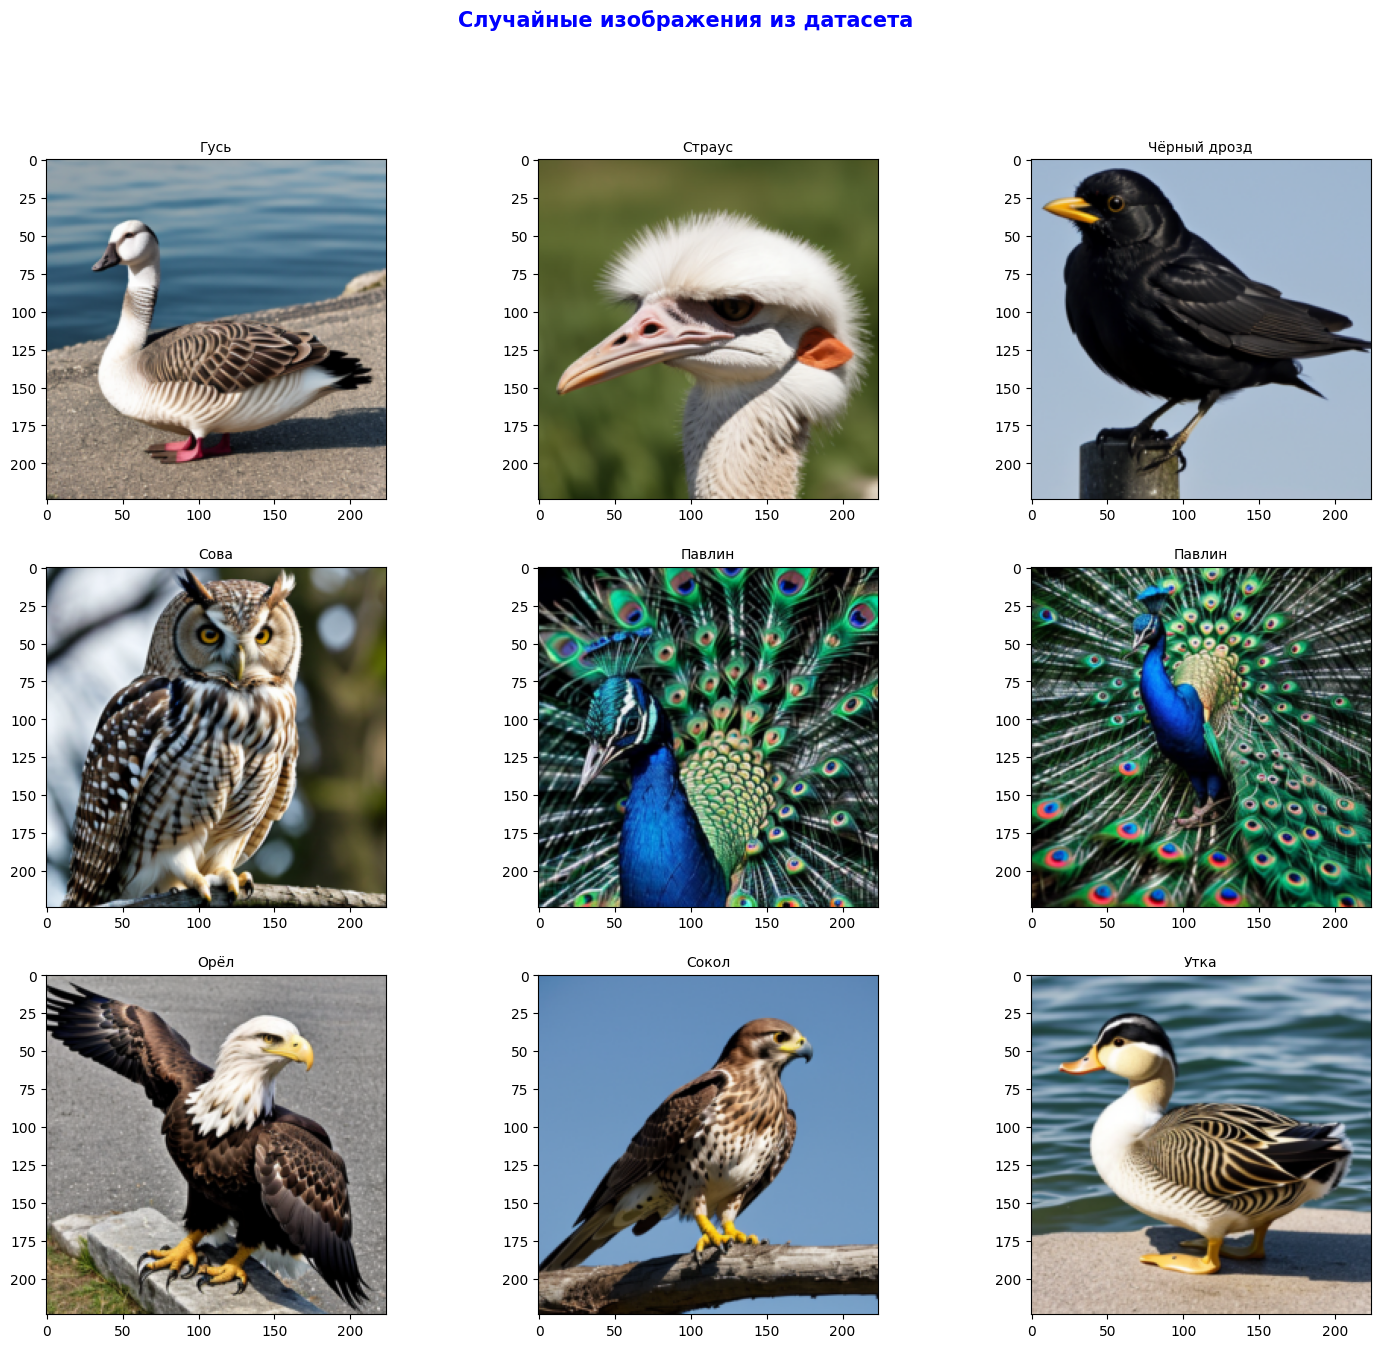

In [26]:
# figure
fig = plt.figure(figsize=(18, 15))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
  # случайный индекс
  random_idx = torch.randint(0, len(dataset_preview), size=[1]).item()
  # image и метка
  img, label = dataset_preview[random_idx]
  fig.add_subplot(rows, cols, i)
  # показать image
  plt.imshow(img.permute(1, 2, 0))
  plt.suptitle('Случайные изображения из датасета', fontsize=15, fontweight='bold', color='blue')
  plt.title(class_names[label], fontsize=10)

## Подготовка данных

In [27]:
# нормализация данных
transform = transforms.Compose([
    transforms.Resize((params_dict['image_height'], params_dict['image_width'])),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # mean - среднее значение для каждого канала, std - стандартное отклонение для каждого канала
])

# загружаем датасет
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# названия классов
class_names = dataset.classes

# разбиваем датасет
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# загружаем датасеты по размерам батча
train_loader = DataLoader(train_dataset, batch_size=params_dict['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params_dict['batch_size'], shuffle=False)

print(f'Количество классов в датасете: {len(class_names)}')
print(f'Всего изображений в датасете: {len(dataset)}')
print(f'Размер тренировочного датасета: {len(train_dataset)} изображений')
print(f'Размер тестового датасета: {len(test_dataset)} изображений')

Количество классов в датасете: 11
Всего изображений в датасете: 2376
Размер тренировочного датасета: 1900 изображений
Размер тестового датасета: 476 изображений


In [28]:
# изображение для pred
pred_dataset = datasets.ImageFolder(root=pred_dataset_path, transform=transform)
pred_loader = DataLoader(pred_dataset, batch_size=params_dict['batch_size'], shuffle=False)

## Функции (обучение, тестирование, метрики модели)

In [29]:
# вычисление метрик
def get_metrics(model, labels, preds) -> dict:
  precision, recall_score, f1_score, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  return({
      'model': model.__str__(),
      'accuracy_score' : round(accuracy_score(labels, preds), 3),
      'precision' : round(precision, 3),
      'recall_score' : round(recall_score, 3),
      'f1-score' : round(f1_score, 3)
  })

In [30]:
# обучение модели
def train(model, dataloader, loss_function, optimizer):
    # модель в режим обучения
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
      inputs = inputs.to(params_dict['device'])
      labels = labels.to(params_dict['device'])
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100
    return average_loss, accuracy

In [31]:
# тестирование модели
def test(model, dataloader, loss_function):
    # модель в режим вычисления
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    # отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(params_dict['device'])
            labels = labels.to(params_dict['device'])
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # всего
            total += labels.size(0)
            # верные
            correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100
    return average_loss, accuracy

In [32]:
# предсказание (на выходе два списка: preds и labels)
def predict(model, dataloader):
    # модель в режим вычисления
    model.eval()
    all_preds = []
    all_labels = []
    # отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(params_dict['device'])
            labels = labels.to(params_dict['device'])
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

## Linear Model

In [34]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(3*params_dict['image_height'] * params_dict['image_width'], 100)
        self.activation = nn.Sigmoid()
        self.fc_2 = nn.Linear(100, len(class_names))
    def forward(self, x: torch.Tensor):
        x = x.view((-1, 3 * params_dict['image_height'] * params_dict['image_width']))
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        return x

## CNN Model

In [35]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1-й свёрточный слой. in_channels=3, т.к. изображение цветное; out_channels=16
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.activation = nn.Tanh()         # Функция активации - гиперболический тангенс
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))    # pooling
        # 2-й свёрточный слой.
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 3-й свёрточный слой.
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        # линейный слой
        self.fc = nn.Linear(56*56*32, len(class_names))
    def forward(self, x: torch.Tensor): # размерность тензора: Batch * C * H * W: 64 * 3 * 224 * 224
        x = self.conv_1(x)              # размерность тензора: Batch * C * H * W: 64 * 16 * 224 * 224
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 16 * 224 * 224
        x = self.pool(x)                # размерность тензора: Batch * C * H * W: 64 * 16 * 112 * 112
        x = self.conv_2(x)              # размерность тензора: Batch * C * H * W: 64 * 32 * 112 * 112
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 32 * 112 * 112
        x = self.pool(x)                # размерность тензора: Batch * C * H * W: 64 * 32 * 56 * 56
        x = self.conv_3(x)              # размерность тензора: Batch * C * H * W: 64 * 32 * 56 * 56
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 32 * 56 * 56
        x = x.view((-1, 56*56*32))      # размерность тензора: Batch * C * H * W: 64 * (56*56*32)
        x = self.fc(x)                  # размерность тензора: Batch * C * H * W: 64 * len(class_names)
        return x

## ResNet50 Model

In [36]:
# ResNet
resnet_model = models.resnet50(pretrained=True)
resnet_model.classifier = nn.Linear(in_features=resnet_model.fc.in_features, out_features=len(class_names))

## Тренировка модели

In [37]:
# модель
# model = LinearModel()
model = CNNModel()
# model = resnet_model

# сводная информация о модели
summary(model.to(params_dict['device']), (3, params_dict['image_height'], params_dict['image_width']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              Tanh-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              Tanh-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           9,248
              Tanh-8           [-1, 32, 56, 56]               0
            Linear-9                   [-1, 11]       1,103,883
Total params: 1,118,219
Trainable params: 1,118,219
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 22.20
Params size (MB): 4.27
Estimated Total Size (MB): 27.04
-------------------------------------

In [20]:
# оптимизатор
# optimizer = torch.optim.Adam(lr=params_dict['learning_rate'], params=model.parameters(), weight_decay=1e-3)
optimizer = torch.optim.SGD(lr=params_dict['learning_rate'], params=model.parameters())

for epoch in tqdm(range(params_dict['num_epochs'])):
    train_loss, train_accuracy = train(model=model, dataloader=train_loader, loss_function=params_dict['loss_function'], optimizer=optimizer)
    test_loss, test_accuracy = test(model=model, dataloader=train_loader, loss_function=params_dict['loss_function'])
    print(f'Epoch [{epoch + 1}/{params_dict["num_epochs"]}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print(f'Обучение завершено. Модель:\n{model.__str__()}')

 20%|██        | 1/5 [01:58<07:52, 118.07s/it]

Epoch [1/5], Train Loss: 7.4212, Train Accuracy: 0.00%, Test Loss: 5.4899, Test Accuracy: 6.10%


 40%|████      | 2/5 [03:28<05:05, 101.82s/it]

Epoch [2/5], Train Loss: 2.0208, Train Accuracy: 65.85%, Test Loss: 2.1613, Test Accuracy: 53.66%


 60%|██████    | 3/5 [04:59<03:13, 96.84s/it] 

Epoch [3/5], Train Loss: 0.5916, Train Accuracy: 95.12%, Test Loss: 0.4981, Test Accuracy: 92.68%


 80%|████████  | 4/5 [06:36<01:36, 96.77s/it]

Epoch [4/5], Train Loss: 0.1478, Train Accuracy: 100.00%, Test Loss: 0.2893, Test Accuracy: 100.00%


100%|██████████| 5/5 [08:09<00:00, 97.93s/it]

Epoch [5/5], Train Loss: 0.0732, Train Accuracy: 100.00%, Test Loss: 0.1308, Test Accuracy: 100.00%
Обучение завершено. Модель:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## Оценка модели

In [22]:
# на тренировочном датасете
preds_train, labels_train = predict(model, train_loader)
train_dict = get_metrics(model, labels_train, preds_train)
print('Метрики на тренировочном датасете:')
train_dict

Метрики на тренировочном датасете:


{'model': 'ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU(inplace=True)\n  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n  (layer1): Sequential(\n    (0): Bottleneck(\n      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU(inplace=True)\n      (downsample): Sequential(\n        (0): Conv2d(64, 256, kerne

In [23]:
# на тестовом датасете
preds_test, labels_test = predict(model, test_loader)
test_dict = get_metrics(model, labels_test, preds_test)
print('Метрики на тестовом датасете:')
test_dict

Метрики на тестовом датасете:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'model': 'ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU(inplace=True)\n  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n  (layer1): Sequential(\n    (0): Bottleneck(\n      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU(inplace=True)\n      (downsample): Sequential(\n        (0): Conv2d(64, 256, kerne

## Прогноз и визуализация

In [45]:
# классификация изображений
def get_classes(model, loader, class_names):
  # список классов
  class_list = []
  model.eval()
  with torch.no_grad():
    for inputs, _ in loader:
      inputs = inputs.to(params_dict['device'])
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for i in range(inputs.size()[0]):
        # если значение больше количества известных классов
        if preds[i] >= len(class_names):
          class_list.append('Неизвестный мне персонаж')
        else:
          class_list.append(class_names[preds[i]])
  return class_list

In [46]:
get_classes(model=model, loader=pred_loader, class_names=class_names)

['Утка']

In [39]:
def visualization_and_classification(model, loader, class_names, num_images=6):
    model.eval()
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(params_dict['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # визуализация каждого images
            for i in range(inputs.size()[0]):
                if i == num_images:
                    return
                # image на CPU и корректируем каналы
                img = inputs[i].cpu().permute(1, 2, 0)
                # обратная нормализация
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])

                fig.add_subplot(num_images // 3, 3, i + 1)
                plt.imshow(img)

                # если значение больше количества известных классов
                if preds[i] >= len(class_names):
                  image_title = 'Неизвестный мне персонаж'
                else:
                  image_title = class_names[preds[i]]

                plt.title(image_title)
    plt.show()

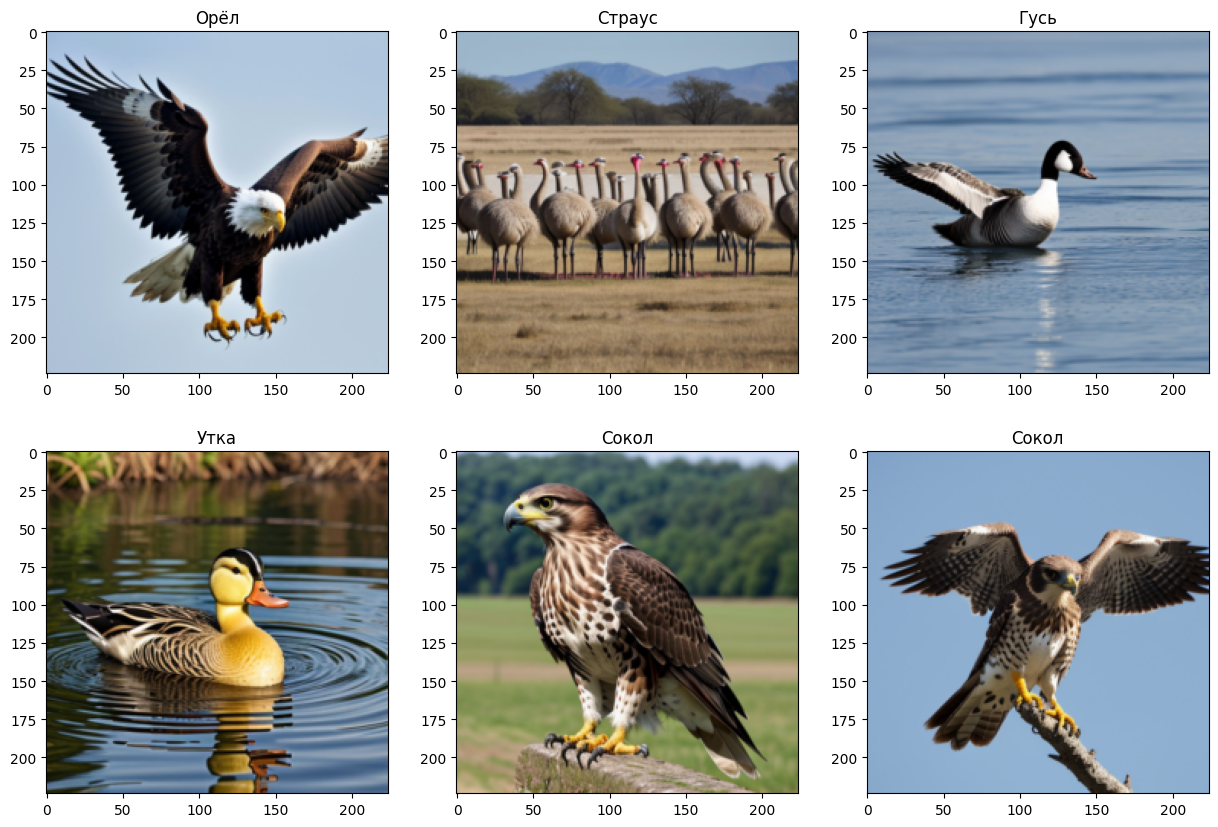

In [50]:
visualization_and_classification(model, test_loader, class_names)

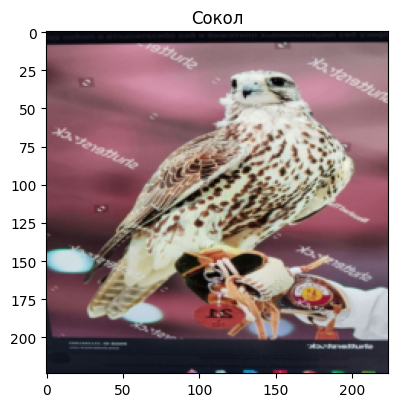

In [49]:
visualization_and_classification(model, pred_loader, class_names)

## Сохранение и загрузка модели

In [51]:
# torch.save(model, '/content/drive/MyDrive/Models/animals_linear_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/animals_cnn_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/animals_resnet50_model.pth')

# torch.save(model, '/content/drive/MyDrive/Models/birds_linear_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/birds_cnn_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/birds_resnet50_model.pth')

# torch.save(model, '/content/drive/MyDrive/Models/fanily_linear_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/family_cnn_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/family_resnet50_model.pth')

In [48]:
# model = torch.load('/content/drive/MyDrive/Models/animals_linear_model.pth', map_location=params_dict['device'])
# model = torch.load('/content/drive/MyDrive/Models/animals_cnn_model.pth', map_location=params_dict['device'])
# model = torch.load('/content/drive/MyDrive/Models/animals_resnet50_model.pth', map_location=params_dict['device'])

# model = torch.load('/content/drive/MyDrive/Models/birds_linear_model.pth', map_location=params_dict['device'])
# model = torch.load('/content/drive/MyDrive/Models/birds_cnn_model.pth', map_location=params_dict['device'])
model = torch.load('/content/drive/MyDrive/Models/birds_resnet50_model.pth', map_location=params_dict['device'])

# model = torch.load('/content/drive/MyDrive/Models/family_resnet50_model.pth', map_location=params_dict['device'])

<ipython-input-48-6ef5172a338e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Models/birds_resnet50_model.pth', map_location=pa

## TelegramBot (aiogram)

In [13]:
! pip install aiogram

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 8.5 MB/s eta 0:00:00


In [14]:
! pip install asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 2.5 MB/s eta 0:00:00


## Импорты

In [52]:
import asyncio
import nest_asyncio
from aiogram.fsm.storage.memory import MemoryStorage
from aiogram import Bot, Dispatcher
from aiogram import F, Router
from aiogram.filters import Command
from aiogram.types import Message
from aiogram.utils.keyboard import ReplyKeyboardBuilder
from aiogram.types import ReplyKeyboardMarkup
from PIL import Image

In [53]:
async def main(maintenance_mode: bool = False):

  # BOT_TOKEN. В общем доступе не выложен.
  # BOT_TOKEN = 'BOT_TOKEN'
  bot = Bot(token=BOT_TOKEN)
  # диспетчер обработчиков
  dp = Dispatcher(maintenance_mode=maintenance_mode, storage=MemoryStorage())
  router = Router()

  # Создаёт ReplyKeyboard
  async def get_reply_keyboard(buttons_text: list, adjust: list, resize_keyboard: bool = True, one_time_keyboard: bool = False) -> ReplyKeyboardMarkup:
      builder = ReplyKeyboardBuilder()
      for button_text in buttons_text:
          builder.button(text=button_text)
      builder.adjust(*adjust)
      return builder.as_markup(resize_keyboard=resize_keyboard, one_time_keyboard=one_time_keyboard)

  # Команда start/старт
  @router.message(Command(commands=['start', 'старт']))
  async def cmd_start(message: Message):
    try:
      keyboard = await get_reply_keyboard(buttons_text=['🦆-linear', '🦆-cnn', '🦆-resnet50', '🐕-linear', '🐕-cnn', '🐕-resnet50', '👱‍♂️-resnet50'], adjust=[3, 3, 1])
      await message.answer(text=f'Я умею классифицировать изображения.\nПожалуйста, выберите одну из {len(models)} обученных моделей:', reply_markup=keyboard)
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - birds, модель - linear
  @router.message(F.text == '🦆-linear')
  async def set_birds_linear(message: Message):
    try:
      global model, class_names
      model = models['birds_linear']
      class_names = all_class_names['birds']

      await message.answer(text=f'Вы выбрали линейную модель\nПожалуйста, отправьте мне фото птицы')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - birds, модель - cnn
  @router.message(F.text == '🦆-cnn')
  async def set_birds_cnn(message: Message):
    try:
      global model, class_names
      model = models['birds_cnn']
      class_names = all_class_names['birds']
      await message.answer(text=f'Вы выбрали cnn-модель\nПожалуйста, отправьте мне фото птицы')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - birds, модель - resnet50
  @router.message(F.text == '🦆-resnet50')
  async def set_birds_resnet50(message: Message):
    try:
      global model, class_names
      model = models['birds_resnet50']
      class_names = all_class_names['birds']
      await message.answer(text=f'Вы выбрали resnet50-модель\nПожалуйста, отправьте мне фото птицы')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - animals, модель - linear
  @router.message(F.text == '🐕-linear')
  async def set_animals_linear(message: Message):
    try:
      global model, class_names
      model = models['animals_linear']
      class_names = all_class_names['animals']
      await message.answer(text=f'Вы выбрали линейную модель\nПожалуйста, отправьте мне фото животного')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - animals, модель - cnn
  @router.message(F.text == '🐕-cnn')
  async def set_animals_cnn(message: Message):
    try:
      global model, class_names
      model = models['animals_cnn']
      class_names = all_class_names['animals']
      await message.answer(text=f'Вы выбрали cnn-модель\nПожалуйста, отправьте мне фото животного')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - animals, модель - resnet50
  @router.message(F.text == '🐕-resnet50')
  async def set_animals_resnet50(message: Message):
    try:
      global model, class_names
      model = models['animals_resnet50']
      class_names = all_class_names['animals']
      await message.answer(text=f'Вы выбрали resnet50-модель\nПожалуйста, отправьте мне фото животного')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # Датасет - family, модель - resnet50
  @router.message(F.text == '👱‍♂️-resnet50')
  async def set_family_resnet50(message: Message):
    try:
      global model, class_names
      model = models['family_resnet50']
      class_names = all_class_names['family']
      await message.answer(text=f'Вы выбрали resnet50-модель\nПожалуйста, отправьте мне фото человека')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # пользователь отправил photo
  @router.message(F.photo)
  async def get_photo(message: Message):
    try:
      image_path = '/content/drive/MyDrive/Images/Photo_pred/pred/image.png'
      # сохраняем изображение поверх имеющегося
      await message.bot.download(file=message.photo[-1].file_id, destination=image_path)

      pred_dataset = datasets.ImageFolder(root=pred_dataset_path, transform=transform)
      pred_loader = DataLoader(pred_dataset, batch_size=params_dict['batch_size'], shuffle=False)

      class_name = get_classes(model=model, loader=pred_loader, class_names=class_names)[0]

      await message.answer(text=f'Изображение загружено.\n\nЭто {class_name}')
    except Exception as err:
      await message.answer(text='Не понял последнюю команду.\nПовторите, пожалуйста.')

  # пользователь отправил любое сообщение (не photo)
  @router.message()
  async def unknown_message(message: Message):
    try:
      await message.reply(f'Я не знаю что с этим делать')
    except Exception as err:
      await message.answer(text='Я ещё учусь.\nПока я умею только классифицировать изображения.')
    finally:
      await message.answer(text='Я ещё учусь.\nПока я умею только классифицировать изображения.')

  # подключаем обработчики
  dp.include_router(router)
  # Удаляем все обновления, которые произошли после последнего завершения работы бота
  await bot.delete_webhook(drop_pending_updates=True)
  # Поллинг новых апдейтов
  await dp.start_polling(bot)

In [54]:
if __name__ == "__main__":

  # классы для разных датасетов
  all_class_names = {'animals' : ['Антилопа', 'Бизон', 'Бобёр', 'Буйвол', 'Верблюд', 'Волк', 'Выдра', 'Гепард', 'Гиена', 'Гиппопотам', 'Горилла', 'Дельфин',
                                  'Дикобраз', 'Ёж', 'Енот', 'Жираф', 'Игуана', 'Кенгуру', 'Кит', 'Коала', 'Козёл', 'Корова', 'Кошка', 'Краб', 'Крокодил',
                                  'Крот', 'Лемур', 'Леопард', 'Лиса', 'Лягушка', 'Мангус', 'Медведь', 'Морж', 'Овца', 'Олень', 'Осёл', 'Панда', 'Рысь',
                                  'Слон', 'Собака', 'Тюлень', 'Хорёк', 'Шимпанзе', 'Шиншилла', 'Ягуар', 'Ящерица'],
                     'birds' : ['Гусь', 'Орёл', 'Павлин', 'Пингвин', 'Сова', 'Сокол', 'Страус', 'Утка', 'Фламинго', 'Чёрный дрозд', 'Ястреб'],
                     'family' : ['Катя', 'Мама', 'Настя', 'Папа', 'Саша'],
  }

  # модели (загрузка предварительно обученных)
  models = {'birds_linear'     : torch.load('/content/drive/MyDrive/Models/birds_linear_model.pth', map_location=params_dict['device']),
            'birds_cnn'        : torch.load('/content/drive/MyDrive/Models/birds_cnn_model.pth', map_location=params_dict['device']),
            'birds_resnet50'   : torch.load('/content/drive/MyDrive/Models/birds_resnet50_model.pth', map_location=params_dict['device']),
            'animals_linear'   : torch.load('/content/drive/MyDrive/Models/animals_linear_model.pth', map_location=params_dict['device']),
            'animals_cnn'      : torch.load('/content/drive/MyDrive/Models/animals_cnn_model.pth', map_location=params_dict['device']),
            'animals_resnet50' : torch.load('/content/drive/MyDrive/Models/animals_resnet50_model.pth', map_location=params_dict['device']),
            'family_resnet50'  : torch.load('/content/drive/MyDrive/Models/family_resnet50_model.pth', map_location=params_dict['device']),
  }

  # классы и модель при старте бота
  class_names = all_class_names['birds']
  model = models['birds_cnn']

  nest_asyncio.apply()
  # точка входа
  asyncio.run(main())

<ipython-input-54-1408428cbd5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = {'birds_linear'     : torch.load('/content/drive/MyDrive/Models/birds_linear_model